<a href="https://colab.research.google.com/github/Jiseong-Ok/deep-text-recognition-benchmark-benchmark/blob/main/Optical_Character_Recognition_AI_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Git clone & Run Demo

In [ ]:
!pip3 install torch==1.3.1.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 734.6 MB 15 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.3.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.3.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.3.1 which is incompatible.


In [1]:
!pip3 install lmdb pillow torchvision nltk natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/clovaai/deep-text-recognition-benchmark.git

Cloning into 'deep-text-recognition-benchmark'...
remote: Enumerating objects: 495, done.
remote: Total 495 (delta 0), reused 0 (delta 0), pack-reused 495
Receiving objects: 100% (495/495), 3.07 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [ ]:
# !cp /content/TPS-ResNet-BiLSTM-Attn.pth /content/deep-text-recognition-benchmark

In [ ]:
# %cd /content/deep-text-recognition-benchmark

/content/deep-text-recognition-benchmark


In [ ]:
# !CUDA_VISIBLE_DEVICES=0 python3 demo.py \
# --Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn \
# --image_folder demo_image/ \
# --saved_model TPS-ResNet-BiLSTM-Attn.pth

# Train using AI Hub Dataset

## Preprocessing

In [3]:
!cp /content/drive/MyDrive/OCR/AIHubData/textinthewild_data_info.json /content

In [4]:
import json
file = json.load(open('./textinthewild_data_info.json'))

In [5]:
# file['images'][0]['type'] == 'book' # True
signs = [f for f in file['images'] if f['type']=='traffic sign']
len(signs) #26358

26804

In [6]:
annotation = [a for a in file['annotations'] if a['image_id'] == signs[0]['id'] and a['attributes']['class']=='word']
annotation

[{'attributes': {'class': 'word'},
  'bbox': [648, 942, 38, 124],
  'id': '00337614',
  'image_id': '00014538',
  'text': '과속금지'}]

In [7]:
!cp /content/drive/MyDrive/OCR/AIHubData/01_textinthewild_traffic_sign_images_new.zip /content

In [ ]:
!unzip /content/01_textinthewild_traffic_sign_images_new.zip -d /content/data

In [9]:
import os
len(os.listdir("/content/data/Traffic_Sign"))

16580

In [10]:
signs[0]

{'file_name': 'FF759F1185B33CF403449D7E57A91526.jpg',
 'height': 1440,
 'id': '00014538',
 'type': 'traffic sign',
 'width': 1920}

In [11]:
signs = [x for x in signs if x['file_name'] in os.listdir('/content/data/Traffic_Sign')]

# 폴더 내에 이미지가 있는것들만 남김

In [12]:
len(signs)

16494

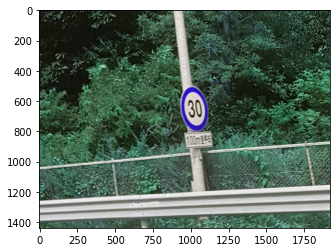

In [13]:
import matplotlib.pyplot as plt
import cv2
img = cv2.imread('./data/Traffic_Sign/'+signs[0]['file_name'])
plt.imshow(img)

## Data Split

In [ ]:
# os.listdir('/content/signs/Traffic_Sign')[0]

'535CD920E4F562F4CBA529A375BFBA06.jpg'

In [ ]:
# signs[0]['file_name']

'FF256E640E07807A971AB0F47DFE5C9E.jpg'

In [ ]:
# ocr_sign_files = os.listdir('/content/signs/Traffic_Sign')
# len(ocr_sign_files)

16580

In [ ]:
# orc_sign_files2 = []
# for x in ocr_sign_files:
#     for y in signs:
#         if x == y['file_name']:
#             orc_sign_files2.append(x)

In [ ]:
# len(orc_sign_files2)

16494

In [ ]:
import random
import os

ocr_sign_files = os.listdir('/content/data/Traffic_Sign')
len(ocr_sign_files) # 37220

random.shuffle(ocr_sign_files)

n_train = int(len(ocr_sign_files) * 0.7)
n_validation = int(len(ocr_sign_files) * 0.15)
n_test = int(len(ocr_sign_files) * 0.15)

print(n_train, n_validation, n_test) # 26054 5583 5583

train_files = ocr_sign_files[:n_train]
validation_files = ocr_sign_files[n_train: n_train+n_validation]
test_files = ocr_sign_files[-n_test:]

## train/validation/test 이미지들에 해당하는 id 값을 저장

train_img_ids = {}
validation_img_ids = {}
test_img_ids = {}

for image in file['images']:
    if image['file_name'] in train_files:
        train_img_ids[image['file_name']] = image['id']
    elif image['file_name'] in validation_files:
        validation_img_ids[image['file_name']] = image['id']
    elif image['file_name'] in test_files:
        test_img_ids[image['file_name']] = image['id']

## train/validation/test 이미지들에 해당하는 annotation 들을 저장

train_annotations = {f:[] for f in train_img_ids.keys()}
validation_annotations = {f:[] for f in validation_img_ids.keys()}
test_annotations = {f:[] for f in test_img_ids.keys()}

train_ids_img = {train_img_ids[id_]:id_ for id_ in train_img_ids}
validation_ids_img = {validation_img_ids[id_]:id_ for id_ in validation_img_ids}
test_ids_img = {test_img_ids[id_]:id_ for id_ in test_img_ids}

for idx, annotation in enumerate(file['annotations']):
    if idx % 5000 == 0:
        print(idx,'/',len(file['annotations']),'processed')
    if annotation['attributes']['class'] != 'word':
        continue
    if annotation['image_id'] in train_ids_img:
        train_annotations[train_ids_img[annotation['image_id']]].append(annotation)
    elif annotation['image_id'] in validation_ids_img:
        validation_annotations[validation_ids_img[annotation['image_id']]].append(annotation)
    elif annotation['image_id'] in test_ids_img:
        test_annotations[test_ids_img[annotation['image_id']]].append(annotation)

with open('train_annotation.json', 'w') as file:
    json.dump(train_annotations, file)
with open('validation_annotation.json', 'w') as file:
    json.dump(validation_annotations, file)
with open('test_annotation.json', 'w') as file:
    json.dump(test_annotations, file)

## Create DataSet
- Imdb dataset

In [46]:
# shutil.rmtree('/content/deep-text-recognition-benchmark/data/test')
# shutil.rmtree('/content/deep-text-recognition-benchmark/data/train')
# shutil.rmtree('/content/deep-text-recognition-benchmark/data/validation')
# shutil.rmtree('/content/deep-text-recognition-benchmark/data_lmdb')
# shutil.rmtree('/content/deep-text-recognition-benchmark/data')

In [15]:
!pip install fire

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.9 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=14d457dc09aa1b82e880f49c1985dd6eee1da4c041e02282d296d038a1f030e3
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [16]:
!mkdir /content/deep-text-recognition-benchmark/data/

In [17]:
import shutil
!mkdir /content/deep-text-recognition-benchmark/data/train
!mkdir /content/deep-text-recognition-benchmark/data/validation
!mkdir /content/deep-text-recognition-benchmark/data/test

In [18]:
!pwd

/content


In [50]:
%cd ../

/content


In [19]:
import json
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

## aihub 데이터 annotation을 읽어서 단어 단위로 잘라서 data에 저장하기

data_root_path = '/content/data/Traffic_Sign/'
save_root_path = '/content/deep-text-recognition-benchmark/data/'

test_annotations = json.load(open('./test_annotation.json'))
gt_file = open(save_root_path+'gt_test.txt', 'w')
for file_name in tqdm(test_annotations):
    annotations = test_annotations[file_name]
    image = cv2.imread(data_root_path+file_name)
    for idx, annotation in enumerate(annotations):
        x,y,w,h = annotation['bbox']
        if x<= 0 or y<= 0 or w <= 0 or h <= 0:
            continue
        text = annotation['text']
        crop_img = image[y:y+h,x:x+w]
        crop_file_name = file_name[:-4]+'_{:03}.jpg'.format(idx+1)
        cv2.imwrite(save_root_path+'test/'+crop_file_name, crop_img)
        gt_file.write("test/{}\t{}\n".format(crop_file_name, text))

validation_annotations = json.load(open('./validation_annotation.json'))
gt_file = open(save_root_path+'gt_validation.txt', 'w')
for file_name in tqdm(validation_annotations):
    annotations = validation_annotations[file_name]
    image = cv2.imread(data_root_path+file_name)
    for idx, annotation in enumerate(annotations):
        x,y,w,h = annotation['bbox']
        if x<= 0 or y<= 0 or w <= 0 or h <= 0:
            continue        
        text = annotation['text']
        crop_img = image[y:y+h,x:x+w]
        crop_file_name = file_name[:-4]+'_{:03}.jpg'.format(idx+1)
        cv2.imwrite(save_root_path+'validation/'+crop_file_name, crop_img)
        gt_file.write("validation/{}\t{}\n".format(crop_file_name, text))
        
train_annotations = json.load(open('./train_annotation.json'))
gt_file = open(save_root_path+'gt_train.txt', 'w')
for file_name in tqdm(train_annotations):
    annotations = train_annotations[file_name]
    image = cv2.imread(data_root_path+file_name)
    for idx, annotation in enumerate(annotations):
        x,y,w,h = annotation['bbox']
        if x<= 0 or y<= 0 or w <= 0 or h <= 0:
            continue        
        text = annotation['text']
        crop_img = image[y:y+h,x:x+w]
        crop_file_name = file_name[:-4]+'_{:03}.jpg'.format(idx+1)
        cv2.imwrite(save_root_path+'train/'+crop_file_name, crop_img)
        gt_file.write("train/{}\t{}\n".format(crop_file_name, text))

100%|██████████| 11606/11606 [11:09<00:00, 17.34it/s]


In [20]:
len(os.listdir("/content/deep-text-recognition-benchmark/data/test")), len(os.listdir("/content/deep-text-recognition-benchmark/data/train")), len(os.listdir("/content/deep-text-recognition-benchmark/data/validation"))

(6923, 33021, 7070)

In [21]:
%cd ./deep-text-recognition-benchmark

/content/deep-text-recognition-benchmark


In [22]:
!python3 create_lmdb_dataset.py --inputPath data/ --gtFile data/gt_train.txt --outputPath data_lmdb/train
!python3 create_lmdb_dataset.py --inputPath data/ --gtFile data/gt_validation.txt --outputPath data_lmdb/validation


Written 1000 / 32905
Written 2000 / 32905
Written 3000 / 32905
Written 4000 / 32905
Written 5000 / 32905
Written 6000 / 32905
Written 7000 / 32905
Written 8000 / 32905
Written 9000 / 32905
Written 10000 / 32905
Written 11000 / 32905
Written 12000 / 32905
Written 13000 / 32905
Written 14000 / 32905
Written 15000 / 32905
Written 16000 / 32905
Written 17000 / 32905
Written 18000 / 32905
Written 19000 / 32905
Written 20000 / 32905
Written 21000 / 32905
Written 22000 / 32905
Written 23000 / 32905
Written 24000 / 32905
Written 25000 / 32905
Written 26000 / 32905
Written 27000 / 32905
Written 28000 / 32905
Written 29000 / 32905
Written 30000 / 32905
Written 31000 / 32905
Written 32000 / 32905
Created dataset with 32905 samples
Written 1000 / 7070
Written 2000 / 7070
Written 3000 / 7070
Written 4000 / 7070
Written 5000 / 7070
Written 6000 / 7070
Written 7000 / 7070
Created dataset with 7070 samples


train.py 수정해주기

---
- character에서 defult='0123456789abcdefghijklmnopqrstuvwxyz'를 학습할 문자들로 고치기
- select_data에서 default='MJ-ST'를 '/'로 수정
MJ, ST 데이터셋이 아닌 우리가 만든 커스텀 데이터셋을 사용할 것이므로
- batch_ratio에서 default='0.5-0.5'를 '1'로 수정
커스텀 데이터셋이 1종류이기 때문에


In [23]:
# %cd ./deep-text-recognition-benchmark

[Errno 2] No such file or directory: './deep-text-recognition-benchmark'
/content/deep-text-recognition-benchmark


In [24]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!CUDA_VISIBLE_DEVICES=0,1,2 python3 train.py --train_data data_lmdb/train --valid_data data_lmdb/validation \
	--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction CTC \
	--data_filtering_off --workers 0 --imgH 64 --imgW 200

--------------------------------------------------------------------------------
dataset_root: data_lmdb/train
opt.select_data: ['/']
opt.batch_ratio: ['1']
--------------------------------------------------------------------------------
dataset_root:    data_lmdb/train	 dataset: /
sub-directory:	/.	 num samples: 32896
num total samples of /: 32896 x 1.0 (total_data_usage_ratio) = 32896
num samples of / per batch: 64 x 1.0 (batch_ratio) = 64
--------------------------------------------------------------------------------
Total_batch_size: 64 = 64
--------------------------------------------------------------------------------
dataset_root:    data_lmdb/validation	 dataset: /
sub-directory:	/.	 num samples: 7095
--------------------------------------------------------------------------------
model input parameters 64 200 20 1 512 256 1011 25 TPS ResNet BiLSTM CTC
Skip Transformation.LocalizationNetwork.localization_fc2.weight as it is already initialized
Skip Transformation.Localization